In [1]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [2]:
pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [3]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install --upgrade seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Kanha@123',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r"C:\Users\dasta\pythonproject"

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    try:
        file_path = os.path.join(folder_path, csv_file)
        
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Replace NaN with None to handle SQL NULL
        df = df.where(pd.notnull(df), None)
        
        # Debugging: Check for NaN values
        print(f"Processing {csv_file}")
        print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

        # Clean column names
        df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

        # Generate the CREATE TABLE statement with appropriate data types
        columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
        create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
        cursor.execute(create_table_query)

        # Insert DataFrame data into the MySQL table
        for _, row in df.iterrows():
            # Convert row to tuple and handle NaN/None explicitly
            values = tuple(None if pd.isna(x) else x for x in row)
            sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
            cursor.execute(sql, values)

        # Commit the transaction for the current CSV file
        conn.commit()
        print(f"Successfully imported {csv_file}")
    
    except Exception as e:
        print(f"Error importing {csv_file}: {str(e)}")

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Successfully imported customers.csv
Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Successfully imported orders.csv
Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Successfully imported sellers.csv
Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
pro

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
 
db = mysql.connector.connect(host="localhost",username="root",password="Kanha@123",
                          database="ecommerce")
cur=db.cursor()

# 1. List all unique cities where customers are located.


In [7]:
query="""select distinct customer_city from customers"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2 Count the number of orders placed in 2017.

In [8]:
query = """SELECT COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2017"""

cur.execute(query)
data = cur.fetchall()
print("Total orders placed in 2017 are:", data[0][0])

Total orders placed in 2017 are: 180404


# 3. Find the total sales per category.

In [4]:
query=""" select products.product_category category,round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id= order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data=cur.fetchall()
df= pd.DataFrame(data , columns=["Category","Sales"])
print(df)
# df.Category = df.Category.fillna('')
# plt.bar(df["Category"], df["Sales"])
# plt.figure(figsize=(10, 10))

# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# plt.show()

                       Category       Sales
0                 sport leisure  5568510.24
1               home appliances   382129.08
2              Furniture office  2587305.95
3                    Cool Stuff  3118792.00
4                bed table bath  6850214.68
..                          ...         ...
69               party articles    23865.24
70                   La Cuisine    11654.12
71  Fashion Children's Clothing     3142.68
72       insurance and services     1298.04
73               cds music dvds     4797.72

[74 rows x 2 columns]


# 4. Calculate the percentage of orders that were paid in installments.

In [22]:
query=""" select sum(case when payment_installments >= 1 then 1 else 0 end)
/count(*)*100 from payments"""

cur.execute(query)
data=cur.fetchall()
data

[(Decimal('99.9981'),)]

# 5. Count the number of customers from each state. 


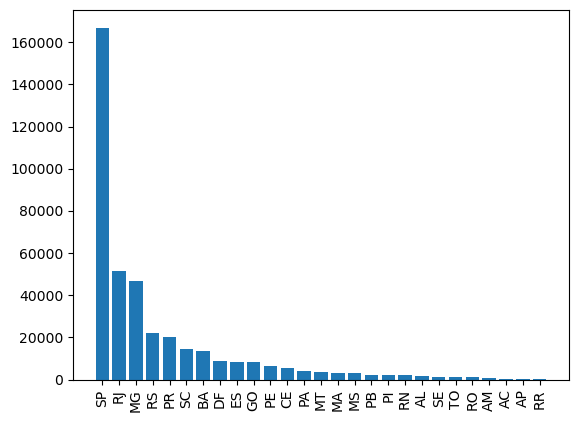

In [6]:
query=""" select customer_state ,count(customer_id)
from customers group by customer_state"""

cur.execute(query)

data=cur.fetchall()

df = pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by="customer_count",ascending=False)
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per month in 2018.

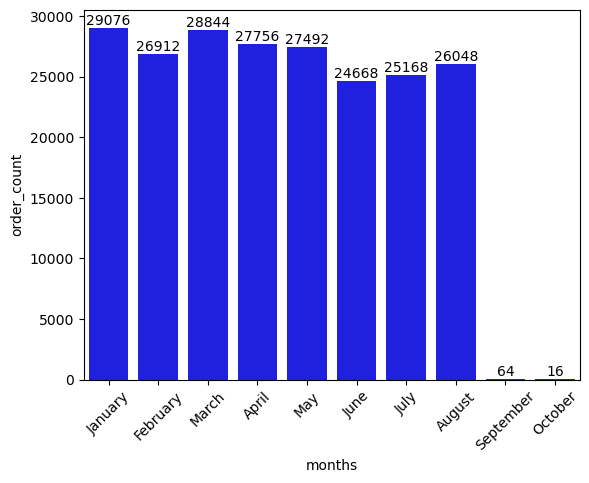

In [44]:
query="""select  monthname(order_purchase_timestamp)months ,count(order_id) from orders
where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns= ["months","order_count"])
o=["January","February","March","April","May","June","July","August","September","October"]

ax=sns.barplot( x= df["months"],y= df["order_count"],order = o,color="blue")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])

plt.show()

# Find the average number of products per order, grouped by customer city.

In [3]:
query=""" with count_per_order as
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id, orders.customer_id)


select customers.customer_city,round(avg(count_per_order.oc),2) average_order
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,treze tilias,5.09
1,indaial,4.46
2,sao jose dos campos,4.55
3,sao paulo,4.62
4,porto alegre,4.70
5,santos,4.65
6,sao francisco do sul,4.94
7,sao vicente,4.36
8,joinville,4.41
9,sao vendelino,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [4]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71


# Identify the correlation between product price and the number of times a product has been purchased.

In [6]:
import numpy as np
cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562
